# Example: Optimal adversaries for convolutional MNIST model

This notebook gives an example where OMLT is used to find adversarial examples for a trained convolutional neural network. We follow the below steps:<br>
1.) A convolutional neural network (CNN) with ReLU activation functions is trained to classify images from the MNIST dataset <br>
2.) OMLT is used to generate a mixed-integer encoding of the trained CNN using the big-M formulation <br>
3.) The model is optimized to find the maximum classification error (defined by an "adversarial" label) over a small input region <br>



## Library Setup
This notebook assumes you have a working PyTorch environment to train the neural network for classification. The neural network is then formulated in Pyomo using OMLT which therefore requires working Pyomo and OMLT installations.

The required Python libraries used this notebook are as follows: <br>
- `numpy`: used for manipulate input data <br>
- `torch`: the machine learning language we use to train our neural network
- `torchvision`: a package containing the MNIST dataset
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `onnx`: used to express trained neural network models
- `omlt`: the package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

**NOTE:** This notebook also assumes you have a working MIP solver executable (e.g., CBC, Gurobi) to solve optimization problems in Pyomo. The open-source solver CBC is called by default.

In [48]:
#Import requisite packages
#data manipulation
import numpy as np
import tempfile

#pytorch for training neural network
import torch, torch.onnx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

## Import the Data and Train a Neural Network

We begin by loading the MNIST dataset as `DataLoader` objects with pre-set training and testing batch sizes:

In [49]:
#set training and test batch sizes
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}

#build DataLoaders for training and test sets
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
dataset2 = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

## Build a MIP Formulation for the Trained Convolutional Neural Network

We are now ready to use OMLT to formulate the trained model within a Pyomo optimization model. We use a  binary variable representation to represent the ReLU activation logic which is created automatically using the `FullSpaceNNFormulation` object (one could also simply use the `ReluBigFormulation` object).

First, we define a neural network without the final `LogSoftmax` activation. Although this activation helps greatly in training the neural network model, it is not trivial to encode in the optimization model. The ranking of the output labels remains the same without the activation, so it can be omitted when finding optimal adversaries. 

In [50]:
hidden_size = 10

class NoSoftmaxNet(nn.Module):
    #define layers of neural network
    def __init__(self):
        super().__init__()
        self.conv1  = nn.Conv2d(1, 2, (4,4), (2,2), 0)
        self.conv2  = nn.Conv2d(2, 2, (4,4), (2,2), 0)
        self.hidden1 = nn.Linear(5 * 5 * 2, hidden_size)
        self.output  = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()

    #define forward pass of neural network
    def forward(self, x):
        self.x1 = self.conv1(x)
        self.x2 = self.relu(self.x1)
        self.x3 = self.conv2(self.x2)
        self.x4 = self.relu(self.x3)
        self.x5 = self.hidden1(self.x4.view((-1,5*5*2)))
        self.x6 = self.relu(self.x5)
        x = self.output(self.x6)    
        return x


In [51]:
import torch

# Path to the saved model
model_path = "cnn_model.pth"

# Load the model
model = NoSoftmaxNet()
model.load_state_dict(torch.load(model_path))

print("Model loaded successfully.")

Model loaded successfully.


Next, we define an instance of the optimal adversary problem. We formulate the optimization problem as: <br>

$
\begin{align*} 
& \max_x \ y_k - y_j \\
& s.t. y_k = N_k(x) \\ 
&\quad |x - \bar{x}|_\infty \leq 0.05
\end{align*}
$

where $\bar{x}$ corresponds to an image in the test dataset with true label `j`, and $N_k(x)$ is the value of the CNN output corresponding to adversarial label `k` given input `x`. PyTorch needs to trace the model execution to export it to ONNX, so we also define a dummy input tensor `x_temp`.

In [52]:
#load image and true label from test set with index 'problem_index'
problem_index = 0
image = dataset2[problem_index][0].detach().numpy()
label = dataset2[problem_index][1]

#define input region defined by infinity norm
epsilon_infty = 0.1
lb = np.maximum(0, image - epsilon_infty)
ub = np.minimum(1, image + epsilon_infty)

#save input bounds as dictionary, note that the first index 0 corresponds to the single-channel input
input_bounds = {}
for i in range(28):
    for j in range(28):
        input_bounds[(0,i,j)] = (float(lb[0][i,j]), float(ub[0][i,j])) 
    
#define dummy input tensor    
x = dataset2[problem_index][0].view(-1,1,28,28)

We can now export the PyTorch model as an ONNX model and use `load_onnx_neural_network_with_bounds` to load it into OMLT.

In [53]:
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    #export neural network to ONNX
    torch.onnx.export(
        model,
        x,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    #write ONNX model and its bounds using OMLT
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    #load the network definition from the ONNX model
    network_definition = load_onnx_neural_network_with_bounds(f.name)

As a sanity check before creating the optimization model, we can print the properties of the neural network layers from `network_definition`. This allows us to check input/output sizes, as well as activation functions.

In [54]:
for layer_id, layer in enumerate(network_definition.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

0	InputLayer(input_size=[1, 28, 28], output_size=[1, 28, 28])	linear
1	ConvLayer(input_size=[1, 28, 28], output_size=[2, 13, 13], strides=[2, 2], kernel_shape=(4, 4))	relu
2	ConvLayer(input_size=[2, 13, 13], output_size=[2, 5, 5], strides=[2, 2], kernel_shape=(4, 4))	relu
3	DenseLayer(input_size=[1, 50], output_size=[1, 10])	relu
4	DenseLayer(input_size=[1, 10], output_size=[1, 10])	linear


Finally, we can load `network_definition` as a full-space `FullSpaceNNFormulation` object.OMLT doesn't include a formulation for sigmoid, so define it here

In [55]:
formulation = FullSpaceNNFormulation(network_definition)

## Solve Optimal Adversary Problem in Pyomo

We now encode the trained neural network in a Pyomo model from the `FullSpaceNNFormulation` object. 

In [56]:
#create pyomo model
m = pyo.ConcreteModel()

#create an OMLT block for the neural network and build its formulation
m.nn = OmltBlock()
m.nn.build_formulation(formulation) 

WARNING (W1002): Setting Var 'nn.scaled_inputs[0,7,6]' to a numeric value `0`
outside the bounds (0.229411780834198, 0.42941176891326904).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,7,7]' to a numeric value `0`
outside the bounds (0.6254901885986328, 0.8254902362823486).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,7,8]' to a numeric value `0`
outside the bounds (0.5235294103622437, 0.7235294580459595).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,7,9]' to a numeric value `0`
outside the bounds (0.49215689301490784, 0.6921569108963013).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,7,10]' to a numeric value `0`
outside the bounds (0.135294109582901, 0.33529412746429443).
    See also https://py

WARNING (W1002): Setting Var 'nn.scaled_inputs[0,18,16]' to a numeric value
`0` outside the bounds (0.841176450252533, 1.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,18,17]' to a numeric value
`0` outside the bounds (0.12352941185235977, 0.3235294222831726).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,19,14]' to a numeric value
`0` outside the bounds (0.7666666507720947, 0.9666666984558105).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,19,15]' to a numeric value
`0` outside the bounds (0.8960784077644348, 1.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0,19,16]' to a numeric value
`0` outside the bounds (0.5509803891181946, 0.7509804368019104).
    See also https://pyomo.readthedocs.io/en/

Next, we define an adversarial label as the true label plus one (or zero if the true label is nine), as well as the objective function for optimization.

In [57]:
adversary = 3
m.obj = pyo.Objective(expr=(-(m.nn.outputs[0,adversary]-m.nn.outputs[0,label])))

Finally, we solve the optimal adversary problem using a mixed-integer solver.

In [58]:
solver = pyo.SolverFactory('cbc')
solver.solve(m, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.9.7 
Build Date: Oct 10 2015 
Revision Number: 2226 

command line - C:\CBC\win32-msvc12\bin\cbc.exe -printingOptions all -import C:\Users\HP\AppData\Local\Temp\tmp5jx4z5_o.pyomo.lp -stat=1 -solve -solu C:\Users\HP\AppData\Local\Temp\tmp5jx4z5_o.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 1367 (-2231) rows, 1759 (-1827) columns and 10029 (-4255) elements
Statistics for presolved model
Original problem has 398 integers (398 of which binary)
Presolved problem has 185 integers (185 of which binary)
==== 1749 zero objective 11 different
1 variables have objective of -0.871215
1 variables have objective of -0.64394
1 variables have objective of -0.375368
1 variables have objective of -0.29936
1 variables have objective of -0.124562
1749 variables have objective of 0
1 variables have objective of 0.100883
1 variables have objective of 0.135491
1 variables have objective of 0.256356
1 variables have 

{'Problem': [{'Name': 'unknown', 'Lower bound': -2.42676052, 'Upper bound': -2.42676052, 'Number of objectives': 1, 'Number of constraints': 1367, 'Number of variables': 1759, 'Number of binary variables': 398, 'Number of integer variables': 398, 'Number of nonzeros': 10, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 104.66, 'Wallclock time': 104.66, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 1049, 'Number of created subproblems': 1049}, 'Black box': {'Number of iterations': 152274}}, 'Error rc': 0, 'Time': 104.83161783218384}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [61]:
# print the output of the neural network 
# print the objective function

print(f"true label: {label}")
print(f"adversary label: {adversary}")

print()

for i in range(10):
    print(f"output {i}: {m.nn.outputs[0,i].value}", end = " ")
    print(f"Diff = {m.nn.outputs[0,i].value - m.nn.outputs[0,label].value}")

print()

print(f"objective function: {m.obj()}")

true label: 7
adversary label: 3

output 0: -3.148549 Diff = -3.92826166
output 1: -17.099475 Diff = -17.879187660000003
output 2: -3.1135196 Diff = -3.89323226
output 3: 3.2064732 Diff = 2.42676054
output 4: -12.889942 Diff = -13.669654659999999
output 5: -1.7994534 Diff = -2.57916606
output 6: -23.112097 Diff = -23.89180966
output 7: 0.77971266 Diff = 0.0
output 8: -3.5069715 Diff = -4.28668416
output 9: -3.2160738 Diff = -3.99578646

objective function: -2.42676054


In [62]:
# print the output of the neural network 
# print the objective function

print(f"true label: {label}")
print(f"adversary label: {adversary}")

print()

for i in range(10):
    print(f"output {i}: {m.nn.outputs[0,i].value}", end = " ")
    print(f"Diff = {m.nn.outputs[0,i].value - m.nn.outputs[0,label].value}")

print()

print(f"objective function: {m.obj()}")

true label: 7
adversary label: 3

output 0: -3.148549 Diff = -3.92826166
output 1: -17.099475 Diff = -17.879187660000003
output 2: -3.1135196 Diff = -3.89323226
output 3: 3.2064732 Diff = 2.42676054
output 4: -12.889942 Diff = -13.669654659999999
output 5: -1.7994534 Diff = -2.57916606
output 6: -23.112097 Diff = -23.89180966
output 7: 0.77971266 Diff = 0.0
output 8: -3.5069715 Diff = -4.28668416
output 9: -3.2160738 Diff = -3.99578646

objective function: -2.42676054


In [71]:
# find the infinity norm of the difference between the input image and the adversarial image

adversarial_image = np.zeros((28,28))
for i in range(28):
    for j in range(28):
        adversarial_image[i,j] = m.nn.inputs[0,i,j].value

inf_norm = np.linalg.norm(adversarial_image - image, np.inf)
print(f"inf_norm: {inf_norm}")

inf_norm: 2.2790729173376163


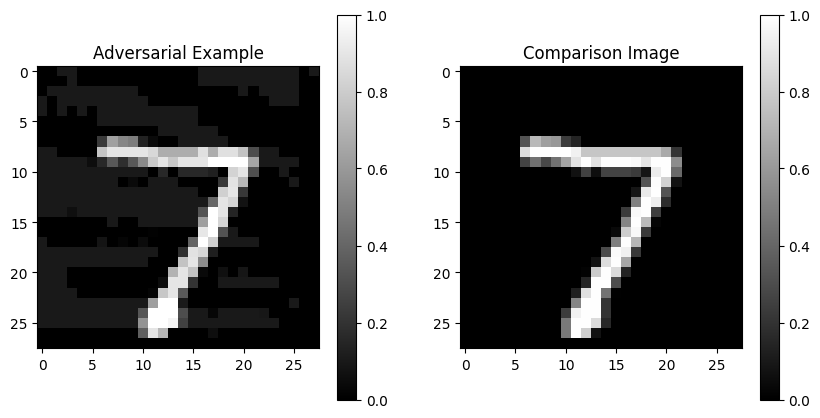

In [69]:
import torch
import matplotlib.pyplot as plt

# Create a torch tensor for the adversarial input, assuming it's flattened
input = torch.zeros((28,28))

# Assuming m.input contains the perturbed image values from a Pyomo model
for i in range(28):
    for j in range(28):
        input[i,j] = m.nn.inputs[0,i,j].value

# Reshape the adversarial example to a 28x28 array for visualization
image_data = input.numpy()  # Convert to numpy array if not already

# Assuming 'image' is another 28x28 array you want to plot for comparison
# Ensure 'image' is also a numpy array and correctly shaped
image = image.reshape(28,28)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the adversarial example
adversarial_display = axes[0].imshow(image_data, cmap='gray')
axes[0].set_title('Adversarial Example')
plt.colorbar(adversarial_display, ax=axes[0])  # Add colorbar associated with the first subplot

# Plot the original or comparison image
comparison_display = axes[1].imshow(image, cmap='gray')
axes[1].set_title('Comparison Image')
plt.colorbar(comparison_display, ax=axes[1])  # Add colorbar associated with the second subplot

plt.show()


### worst adversary 

In [63]:
max_classification_error_check = True
if max_classification_error_check:
    
    max_classification_error = np.inf
    most_adv_label = None

    for adversary in range(10):
        
        if adversary == label:
            continue
        m.obj = pyo.Objective(expr=(-(m.nn.outputs[0,adversary]-m.nn.outputs[0,label])), sense=pyo.minimize)
        pyo.SolverFactory('cbc').solve(m, tee=True)
        print(f"objective function: {m.obj()}")

        if m.obj() < max_classification_error:
            max_classification_error = m.obj()
            most_adv_label = adversary

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Welcome to the CBC MILP Solver 
Version: 2.9.7 
Build Date: Oct 10 2015 
Revision Number: 2226 

command line - C:\CBC\win32-msvc12\bin\cbc.exe -printingOptions all -import C:\Users\HP\AppData\Local\Temp\tmpg22ib1pw.pyomo.lp -stat=1 -solve -solu C:\Users\HP\AppData\Local\Temp\tmpg22ib1pw.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 1367 (-2231) rows, 1759 (-1827) columns and 10029 (-4255) elements
Statistics for presolved model
Original problem has 398 integers (398 of which binary)
Presolved problem has 185 integers (185 of which binary)
==== 1749 zero objective 11 different
1 variables have objective of -0.789456
1 variables have objective of -0.524826
1 variables have o

In [64]:
if max_classification_error_check:

    # print the most adversarial label and the corresponding classification error

    print(f"Most adversarial label: {most_adv_label}")
    print(f"Classification error: {max_classification_error}")

Most adversarial label: 3
Classification error: -2.42676054
